In [3]:
import math
import pdb
import platform

import ai2thor
import copy
import time
import random
import ai2thor.controller
import datetime
import cv2
import os
import matplotlib

import matplotlib.pyplot as plt
import os
import numpy as np
# from utils.mid_level_constants import  scene_start_cheating_init_pose
import sys
from IPython.display import Image, display
import PIL.Image
sys.path.append('../')

from scripts.jupyter_helper import get_reachable_positions
from scripts.stretch_jupyter_helper import get_relative_stretch_current_arm_state,two_dict_equal, ARM_MOVE_CONSTANT, only_reset_scene, transport_wrapper, ADITIONAL_ARM_ARGS, execute_command, WRIST_ROTATION, get_current_wrist_state
from utils.stretch_utils.stretch_constants import STRETCH_ENV_ARGS, STRETCH_MANIPULATHOR_COMMIT_ID
from scripts.dataset_generation.find_categories_to_use import ROBOTHOR_SCENE_NAMES
matplotlib.use('TkAgg')
screen_size=224



In [7]:
action_options = ['m', 'r', 'l', 'b', 'hu', 'hd', 'ao', 'ai', 'go', 'gc', 'wp', 'wn']

kitchens = [f"FloorPlan{i}" for i in range(1, 31)]
living_rooms = [f"FloorPlan{200 + i}" for i in range(1, 31)]
bedrooms = [f"FloorPlan{300 + i}" for i in range(1, 31)]
bathrooms = [f"FloorPlan{400 + i}" for i in range(1, 31)]

all_scenes = kitchens + living_rooms + bedrooms + bathrooms + ROBOTHOR_SCENE_NAMES
NUM_TESTS = 100
EPS_LEN = 500

def setup_thirdparty_camera(controller, camera_position):
    # controller.step('Pass')
    if len(controller.last_event.third_party_camera_frames) > 1:
        controller.step('UpdateThirdPartyCamera',
            thirdPartyCameraId=1, # id is available in the metadata response
            rotation=camera_position['rotation'],
            position=camera_position['position']
            )
    else:
        controller.step('AddThirdPartyCamera', 
            rotation=camera_position['rotation'], 
            position=camera_position['position'],
            fieldOfView=100)

def manual_task(controller, scene_name, logger_number =0, reset=True, final=False, save_frames = False, init_sequence=[], verbose = False):
    if reset or controller.last_event.metadata['sceneName'] != scene_name:
        only_reset_scene(controller, scene_name)
    all_actions = []
    all_action_details = []
    actions_ran_so_far = 0
    while(True):
        visualize(controller, save_frames)
        if len(init_sequence) > 0:
            action = init_sequence[0]
            init_sequence = init_sequence[1:]
        else:
            action = input('action?')
        if action == 'q':
            break
        all_actions.append(action)

        detail = execute_command(controller, action, ADITIONAL_ARM_ARGS)
        if verbose:
            print(detail, controller.last_event.metadata['lastActionSuccess'])
        if not controller.last_event.metadata['lastActionSuccess']:
            print('Failed', controller.last_event)
        all_action_details.append(detail)
        actions_ran_so_far += 1

        # controller.step(action='MoveArm', coordinateSpace="wrist", position=dict(x=0, y=0.2,z=0.2));visualize(controller, save_frames)
        # controller.step(action='RotateWristRelative', yaw=90);visualize(controller, save_frames)

    print(scene_name)
    print(all_actions)
    print(all_action_details)

def visualize(controller, save_frame=False, top_view=True):
    image = controller.last_event.frame
    arm_view = controller.last_event.third_party_camera_frames[0]
    combined=np.concatenate([image, arm_view], 1)
    if top_view:
        camera_position = {
            'position': controller.last_event.metadata['cameraPosition'],
            'rotation': dict(x=90,y=0,z=0)
        }
        camera_position['position']['y'] += 0.5
        setup_thirdparty_camera(controller, camera_position)
        third_view = controller.last_event.third_party_camera_frames[1]
        combined=np.concatenate([combined, third_view], 1)
            
    im = PIL.Image.fromarray(combined)
    display(im)
    
    if STRETCH_ENV_ARGS['renderInstanceSegmentation']:
        print(set([k.split('|')[0] for k in controller.last_event.instance_masks.keys()]))
        print(set([k.split('|')[0] for k in controller.last_event.third_party_instance_masks[0].keys()]))
    
    if save_frame:
        saved_image_folder = '/Users/kianae/Desktop/saved_stretch_images_jupyter'
        os.makedirs(saved_image_folder, exist_ok=True)
        imagename = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S.%f")
        plt.imsave(os.path.join(saved_image_folder, imagename+'.png'), combined)
    



In [5]:
controller = ai2thor.controller.Controller(**STRETCH_ENV_ARGS, commit_id=STRETCH_MANIPULATHOR_COMMIT_ID)


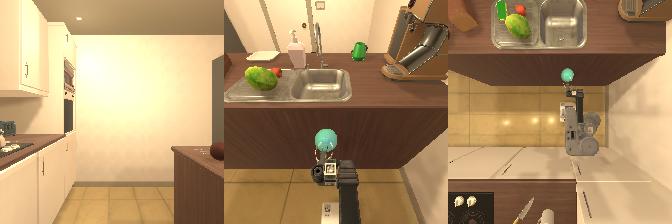

{'CabinetBody', 'Kettle', 'Potato', 'Baseboard.004', 'Spoon', 'Microwave', 'Baseboard.013', 'Toaster', 'Baseboard.019', 'Ceiling', 'Fork', 'CounterTop', 'ButterKnife', 'Cabinet', 'IslandBody', 'Cylinder.023', 'Baseboard.014', 'Baseboard.018', 'Fridge', 'StoveKnob', 'Baseboard.017', 'Floor', 'StoveBurner', 'Spatula'}
{'LightSwitch', 'Fridge', 'Bread', 'Chair', 'Faucet', 'Floor', 'IslandBody', 'Sink', 'Cup', 'Apple', 'SoapBottle', 'Baseboard.004', 'CoffeeMachine', 'CounterTop', 'DoorFrame', 'Plate', 'Lettuce', 'Door', 'Baseboard.018', 'GarbageCan'}
action?l


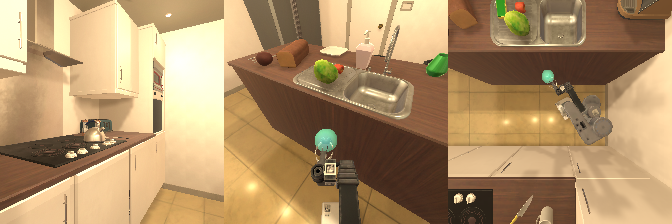

{'CabinetBody', 'Kettle', 'Baseboard.004', 'Microwave', 'PepperShaker', 'Pot', 'Baseboard.013', 'Toaster', 'Baseboard.019', 'Ceiling', 'SaltShaker', 'CounterTop', 'Cabinet', 'Cylinder.023', 'Baseboard.014', 'Baseboard.016', 'StoveKnob', 'Baseboard.017', 'Floor', 'StoveBurner', 'Baseboard.015', 'Spatula'}
{'Chair', 'Sink', 'Potato', 'Baseboard.004', 'Spoon', 'DoorFrame', 'Plate', 'GarbageCan', 'Fork', 'CounterTop', 'ButterKnife', 'IslandBody', 'Cup', 'SoapBottle', 'Lettuce', 'Door', 'Baseboard.018', 'LightSwitch', 'Fridge', 'Faucet', 'Floor', 'Apple', 'Bread'}
action?q
FloorPlan29
['l']
[{'action': 'RotateAgent', 'degrees': -30, 'disableRendering': True, 'returnToStart': True, 'speed': 1}]


In [10]:
manual_task(controller, 'FloorPlan29', reset=False,logger_number =0, init_sequence=[], save_frames=False, final=False)


In [9]:
controller.last_event.metadata['agent']

{'name': 'agent',
 'position': {'x': 1.25, 'y': 0.9317914247512817, 'z': -0.5},
 'rotation': {'x': 0.0, 'y': 270.0, 'z': 0.0},
 'cameraHorizon': -0.0,
 'isStanding': True,
 'inHighFrictionArea': False}

In [11]:
controller.last_event.metadata['agent']

{'name': 'agent',
 'position': {'x': 1.25, 'y': 0.9317914247512817, 'z': -0.5},
 'rotation': {'x': 0.0, 'y': 240.0, 'z': 0.0},
 'cameraHorizon': -0.0,
 'isStanding': True,
 'inHighFrictionArea': False}

In [13]:
controller.last_event.metadata['thirdPartyCameras'][0]

{'thirdPartyCameraId': 0,
 'position': {'x': 1.2981679439544678,
  'y': 1.4405914545059204,
  'z': -0.43142929673194885},
 'rotation': {'x': 45.0, 'y': 330.0, 'z': 0.0},
 'fieldOfView': 90.0}

In [15]:
controller.last_event.metadata['agent']

{'name': 'agent',
 'position': {'x': 1.25, 'y': 0.9317914247512817, 'z': -0.5},
 'rotation': {'x': 0.0, 'y': 240.0, 'z': 0.0},
 'cameraHorizon': -0.0,
 'isStanding': True,
 'inHighFrictionArea': False}

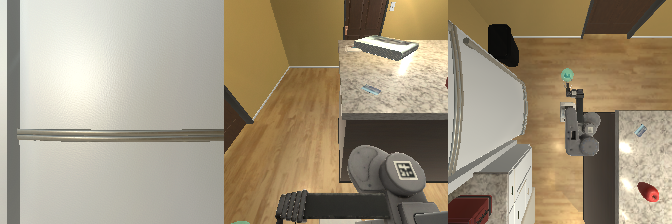

{'Fridge', 'UpperCabinets'}
{'Floor', 'CounterTop', 'StandardIslandHeight', 'CreditCard', 'PaperClutter1', 'Wall', 'Book'}
action?q
FloorPlan1
[]
[]


In [6]:
manual_task(controller, 'FloorPlan1', logger_number =0, init_sequence=[], save_frames=False, final=False)


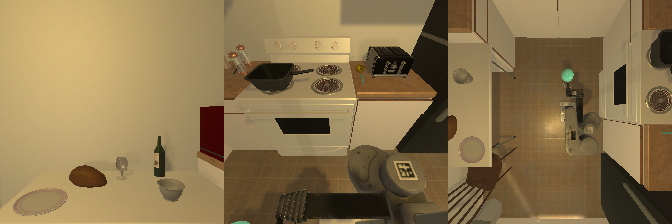

{'WineBottle', 'Cube.164', 'DiningTable', 'CounterTop', 'Room.026', 'Plate', 'Cube.165', 'Bread', 'Bowl', 'Cup', 'Microwave'}
{'Floor', 'Cabinet', 'Cube.164', 'Pot', 'Room.026', 'CounterTop', 'Toaster', 'StoveBase2', 'Drawer', 'Fridge', 'OVENDOOR.001', 'Cube.165', 'StoveKnob', 'OVENDOORBOTTOM.001', 'StoveBurner', 'Ladle'}
action?q
FloorPlan27
[]
[]


In [7]:
manual_task(controller, 'FloorPlan27', logger_number =0, init_sequence=[], save_frames=False, final=False)


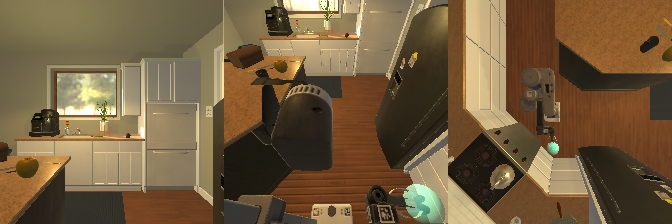

{'Potato', 'SoapBottle', 'Knife', 'CountertopMesh (1)', 'Bread', 'Spatula', 'Floor', 'Cube.054', 'DishSponge', 'Apple', 'Drawer', 'Cube.055', 'CoffeeMachine', 'Window', 'Rug', 'Cube.075', 'Cube.071', 'Faucet', 'IslandMesh', 'CounterTop', 'LightSwitch', 'Sink', 'GarbageCan', 'Cube.072', 'Cube.017', 'Cube.070', 'HousePlant', 'ButterKnife', 'Cube.015', 'Cabinet', 'Cube.047', 'Cube.066', 'DoorFrame', 'Door', 'Cube.049', 'Fridge'}
{'Floor', 'Cabinet', 'Spatula', 'IslandMesh', 'CounterTop', 'Cube.066', 'Apple', 'Drawer', 'Cube.055', 'Cube.049', 'Cube.070', 'Knife', 'Fridge', 'Rug', 'ButterKnife', 'Cube.015', 'Cube.071'}
action?q
FloorPlan30
[]
[]


In [8]:
manual_task(controller, 'FloorPlan30', logger_number =0, init_sequence=[], save_frames=False, final=False)


In [13]:
controller.last_event.metadata['thirdPartyCameras'][0]['fieldOfView']



90.0